<p style="font-size:36px;text-align:center"> <b>WSDM - KKBox's Churn Prediction Challenge</b> </p>

<h1>1. Business Problem</h1>


<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/c/kkbox-churn-prediction-challenge </p>
<p> Data: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data</p>

<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/discussion</p>

<h6> Problem statement : </h6>
<p> Predict whether a user will churn after his/her subscription expires. </p>

<h6> Problem Description : </h6>

<p>The aim of this challenge is to predict whether a user of the music streaming service KKBox will “churn”, i.e. leave this subscription-based service, by analysing the user’s behaviour on the website.</p>

<p>The data comes in the shape of five different files. Four of them contain the user IDs and properties:</p>

<p>In train.csv we find the IDs and whether these users have churned or not.</p>

<p>transactions.csv gives us details like payment method or whether the subscription was cancelled.</p>

<p>user_logs.csv contains the listening behaviour of a user in terms of number of songs played.</p>

<p>members.csv includes the user’s age, city, and such for users that have these membership information.</p>

<p>Finally, sample_submission_zero.csv serves as the test data set for the users for which we are tasked to predict their behaviour.</p>

<h2>2. Mapping the real-world problem to an ML problem</h2>

<h3>2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are two classes of churn that we need to classify a given a data point => Binary class classification problem    
</p>

<h3>2.2. Performance Metric</h3>

Metric(s): 
* log-loss 

<h3>2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.

<h2>2.4. Useful blogs, videos and reference papers</h2>

<p>
https://wsdm-cup-2018.kkbox.events/pdf/7_A_Practical_Pipeline_with_Stacking_Models_for_KKBOXs_Churn_Prediction_Challenge.pdf <br>
https://github.com/RyuJiseung/WSDM_2018/blob/master/kkbox_churn_prediction.pdf <br>
First place solution in Kaggle competition: https://www.youtube.com/watch?v=OEDUzVH1aDI <br>
</p>

<h1>2. Exploratory Data Analysis</h1>

In [476]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


## 2.1 Reading Data

In [477]:
train = pd.read_csv('train_v2.csv')
print('Number of rows & columns',train.shape)
train.head(5)

Number of rows & columns (970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [478]:
members = pd.read_csv('members_v3.csv')
print('Number of rows & columns',members.shape)
members.head(5)

Number of rows & columns (6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [479]:
transactions = pd.read_csv('transactions_v2.csv')
print('Number of rows & columns',transactions.shape)
transactions.head(5)

Number of rows & columns (1431009, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [480]:
log = pd.read_csv('user_logs_v2.csv')
print('Number of rows & columns',log.shape)
log.head(5)

Number of rows & columns (18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [481]:
test = pd.read_csv('sample_submission_v2.csv')
print('Number of rows & columns',test.shape)
test.head(5)

Number of rows & columns (907471, 2)


,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [482]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)
train = pd.merge(train,log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,log,how='left',on='msno',left_index=True, right_index=True)

print('Number of rows & columns',train.shape)
print('Number of rows & columns',test.shape)

Number of rows & columns (970960, 23)
Number of rows & columns (907471, 23)


<h1>3. Exploratory data analysis  </h1>

<h2>3.1 Distribution of churn in train data set </h2>

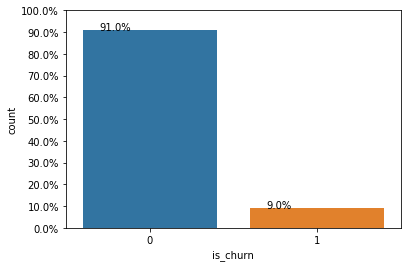

In [483]:
Y=train
total = len(Y)*1.
ax=sns.countplot(x="is_churn", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

<h4> Observation:   </h4>

<p> 91% percent of the users didn't churn</p>

In [484]:
train.describe()

,is_churn,city,bd,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,...,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,970960.000000,860967.000000,860967.000000,860967.000000,8.609670e+05,970960.000000,970960.000000,970960.000000,970960.000000,970960.000000,...,9.709600e+05,970960.000000,9.709600e+05,970960.000000,970960.000000,970960.000000,970960.000000,970960.000000,970960.000000,970960.000000
mean,0.089942,5.937295,13.583854,6.892744,2.013265e+07,37.914433,65.994173,281.738276,281.256855,0.785281,...,2.017110e+07,0.024688,2.017032e+07,6.195742,1.509273,0.943140,1.082089,30.336192,29.090140,7919.157851
std,0.286099,6.441203,20.064040,1.937794,3.011174e+04,4.969543,102.467400,435.120184,435.354774,0.410628,...,3.041643e+03,0.155172,8.916130e+00,12.983454,3.950185,1.908396,3.598354,39.888690,32.061625,9651.201441
min,0.000000,1.000000,-3152.000000,3.000000,2.004033e+07,2.000000,0.000000,0.000000,0.000000,0.000000,...,2.016042e+07,0.000000,2.017030e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.023000
25%,0.000000,1.000000,0.000000,7.000000,2.012021e+07,36.000000,30.000000,99.000000,99.000000,1.000000,...,2.017041e+07,0.000000,2.017031e+07,0.000000,0.000000,0.000000,0.000000,7.000000,8.000000,1967.922250
50%,0.000000,1.000000,0.000000,7.000000,2.014060e+07,40.000000,30.000000,149.000000,149.000000,1.000000,...,2.017042e+07,0.000000,2.017032e+07,2.000000,1.000000,0.000000,0.000000,17.000000,19.000000,4601.594000
75%,0.000000,13.000000,27.000000,9.000000,2.016012e+07,41.000000,30.000000,149.000000,149.000000,1.000000,...,2.017050e+07,0.000000,2.017032e+07,7.000000,2.000000,1.000000,1.000000,37.000000,38.000000,9866.039250
max,1.000000,22.000000,2016.000000,13.000000,2.017042e+07,41.000000,450.000000,2000.000000,2000.000000,1.000000,...,2.036102e+07,1.000000,2.017033e+07,2101.000000,558.000000,241.000000,957.000000,2120.000000,877.000000,515927.542000


### 3.2 Univariate Analysis: City

In [485]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='not churn', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Total')
    plt.title('Number of Churn vs Not Churn')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'churn'))
    plt.show()

In [486]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(20))
    #print("="*50)
    #print(temp.tail(5))

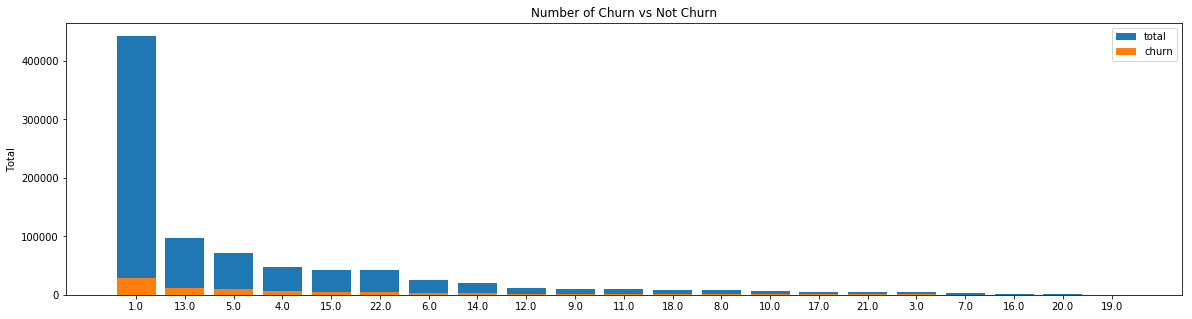

    city  is_churn   total       Avg
0    1.0     28351  442598  0.064056
11  13.0     11950   97136  0.123023
3    5.0      9333   70706  0.131997
2    4.0      6094   47227  0.129036
13  15.0      5538   43187  0.128233
20  22.0      5284   41991  0.125836
4    6.0      3358   26066  0.128827
12  14.0      2370   20013  0.118423
10  12.0      1585   11383  0.139243
7    9.0      1200    9526  0.125971
9   11.0      1096    9138  0.119939
16  18.0       913    7792  0.117171
6    8.0      1021    7589  0.134537
8   10.0       858    6470  0.132612
15  17.0       571    5476  0.104273
19  21.0       765    5199  0.147144
1    3.0       672    5057  0.132885
5    7.0       296    2652  0.111614
14  16.0       104     944  0.110169
18  20.0        72     677  0.106352


In [487]:
univariate_barplots(train, 'city', 'is_churn', False)

__SUMMARY: Every city has similar churn percentage__

### 3.2 Univariate Analysis: Age(bd)

In [488]:
#calculating 0-100th percentile to find  the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =train["bd"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -3152.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 18.0
60 percentile value is 24.0
70 percentile value is 29.0
80 percentile value is 36.0
90 percentile value is nan
100 percentile value is  nan


In [ ]:
## reason for dropping

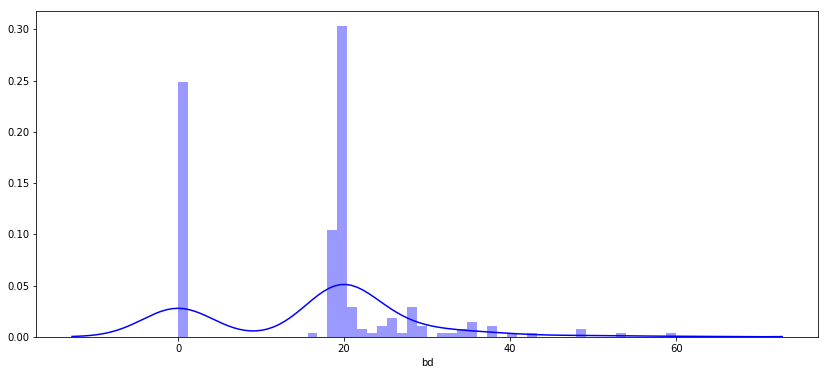

In [489]:
plt.figure(figsize=(14,6))
sns.distplot(train.loc[train['bd'].value_counts()]['bd'].fillna(0),bins=50,color='b')

__SUMMARY: There are outlier and missing values so this cannot be used as a feature __

### 3.3 Univariate Analysis: gender

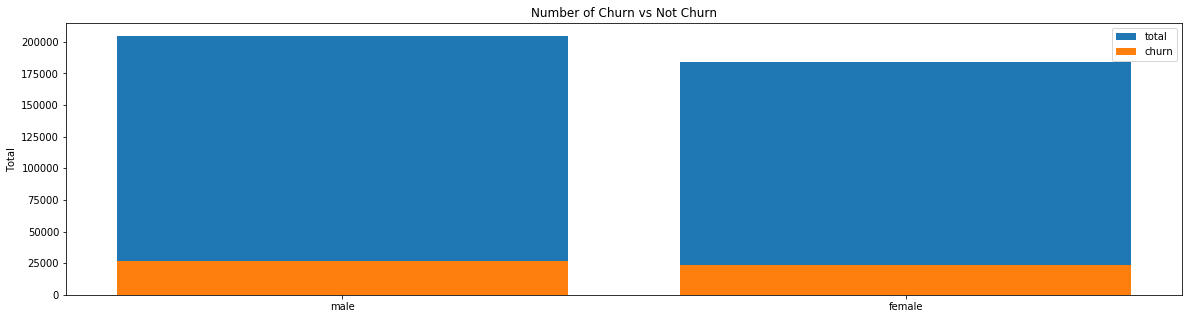

   gender  is_churn   total       Avg
1    male     26396  204561  0.129037
0  female     23940  184344  0.129866


In [490]:
univariate_barplots(train, 'gender', 'is_churn', False)

__SUMMARY: Both of the gender types has similar churn rate and there are missing values so this cannot be used as a feature __

### 3.4 Univariate Analysis: registered_via

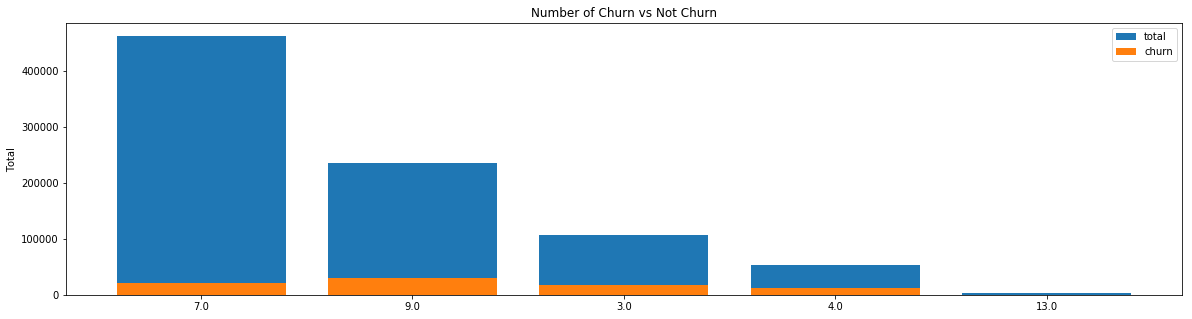

   registered_via  is_churn   total       Avg
2             7.0     20697  462684  0.044732
3             9.0     29893  235689  0.126832
0             3.0     18338  106459  0.172254
1             4.0     12185   52744  0.231022
4            13.0       335    3391  0.098791


In [491]:
univariate_barplots(train, 'registered_via', 'is_churn', False)

__SUMMARY: Registered via type 3 and 4 has more churn rate __

### 3.5 Univariate Analysis: registration_init_time

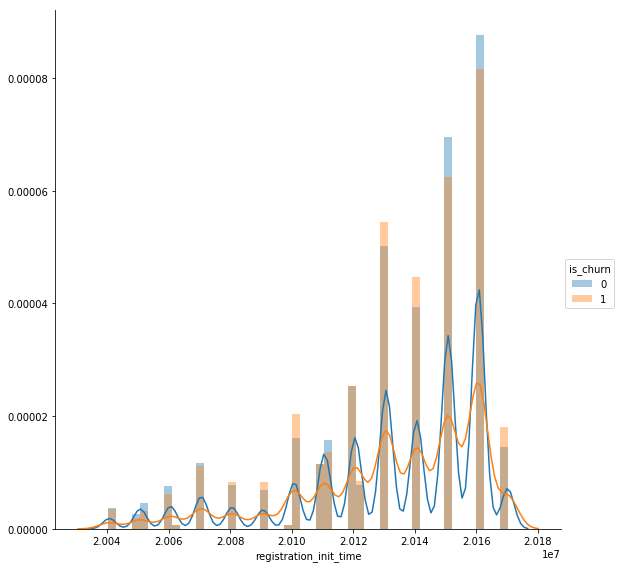

In [492]:
sns.FacetGrid(train, hue="is_churn", size=8) \
   .map(sns.distplot, "registration_init_time") \
   .add_legend();
plt.show();

__SUMMARY: Between the year 2010 and 2017 there are more active users, 2016 and 2017 has more number of churn users __

### 3.6 Univariate Analysis: registration_init_time

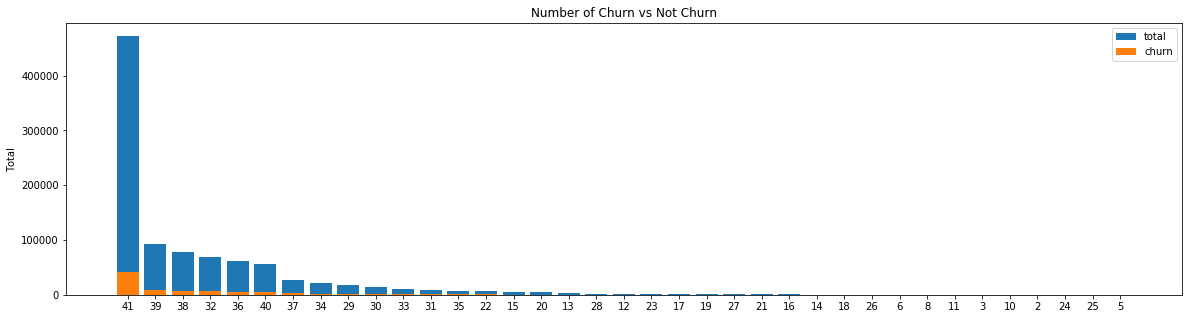

    payment_method_id  is_churn   total       Avg
36                 41     42427  472328  0.089825
34                 39      8304   93016  0.089275
33                 38      7036   78602  0.089514
27                 32      6141   68401  0.089779
31                 36      5487   61748  0.088861
35                 40      5114   56280  0.090867
32                 37      2562   27443  0.093357
29                 34      1888   21019  0.089823
24                 29      1548   17038  0.090856
25                 30      1267   14477  0.087518
28                 33      1046   11352  0.092142
26                 31       775    7980  0.097118
30                 35       601    6626  0.090703
17                 22       604    6491  0.093052
10                 15       457    5226  0.087447
15                 20       414    4484  0.092328
8                  13       353    3478  0.101495
23                 28       211    2333  0.090441
7                  12       169    1930  0.087565


In [493]:
univariate_barplots(train, 'payment_method_id', 'is_churn', False)

__SUMMARY: All the payment id types have similar churn rate __

### 3.7 Univariate Analysis: payment_plan_days

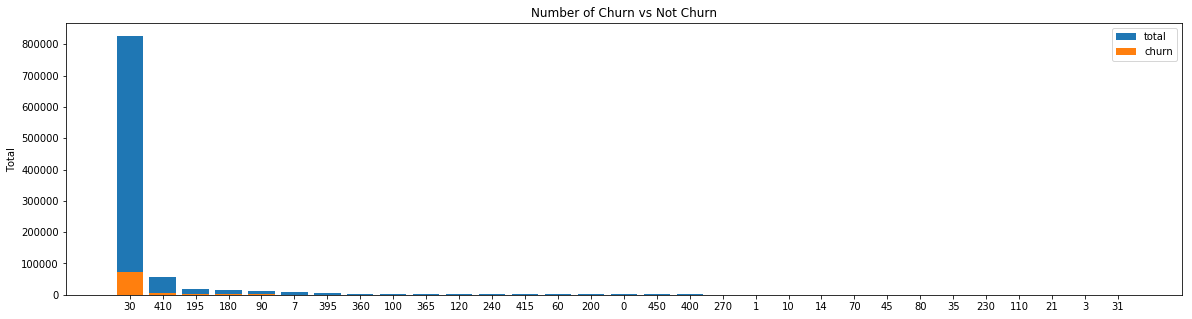

    payment_plan_days  is_churn   total       Avg
7                  30     74373  826572  0.089978
28                410      4985   55696  0.089504
19                195      1744   19387  0.089957
18                180      1513   16166  0.093591
14                 90      1081   13038  0.082911
3                   7       733    8236  0.089000
26                395       612    6642  0.092141
24                360       305    3180  0.095912
15                100       249    2756  0.090348
25                365       249    2539  0.098070
17                120       217    2476  0.087641
22                240       193    2302  0.083840
29                415       198    2264  0.087456
11                 60       177    2107  0.084006
20                200       205    2104  0.097433
0                   0       140    1466  0.095498
30                450       110    1210  0.090909
27                400        97    1197  0.081036
23                270        60     653  0.091884


In [494]:
univariate_barplots(train, 'payment_plan_days', 'is_churn', False)

__SUMMARY: All the plan days have similar churn rate __

### 3.8 Univariate Analysis: plan_list_price

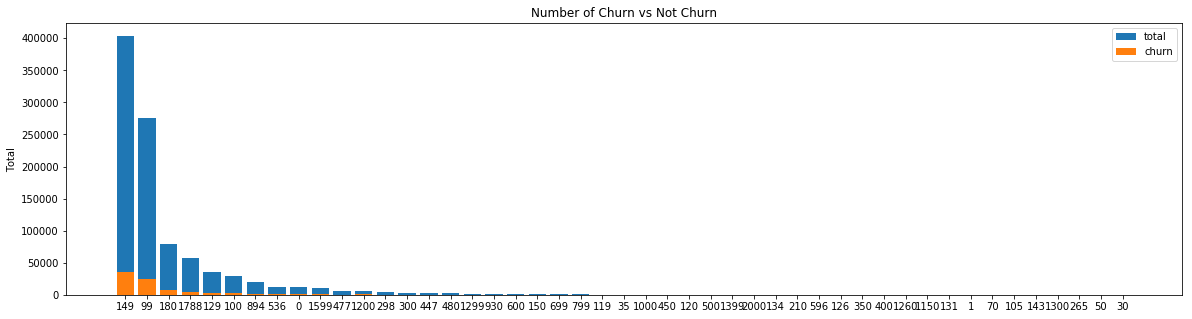

    plan_list_price  is_churn   total       Avg
16              149     36298  403652  0.089924
6                99     24911  276343  0.090145
18              180      7030   78688  0.089340
45             1788      5105   56975  0.089601
12              129      3268   35885  0.091069
7               100      2670   29750  0.089748
35              894      1818   20118  0.090367
30              536      1140   12462  0.091478
0                 0      1119   12452  0.089865
44             1599       899   10010  0.089810
27              477       449    5420  0.082841
39             1200       469    5148  0.091103
21              298       343    4099  0.083679
22              300       254    3228  0.078686
25              447       233    2727  0.085442
28              480       229    2588  0.088485
41             1299       193    2009  0.096068
36              930       185    1897  0.097522
32              600       175    1836  0.095316
17              150       121    1440  0

In [495]:
univariate_barplots(train, 'plan_list_price', 'is_churn', False)

__SUMMARY: Almost all the higher price has higher churn rate __

### 3.9 Univariate Analysis: actual_amount_paid

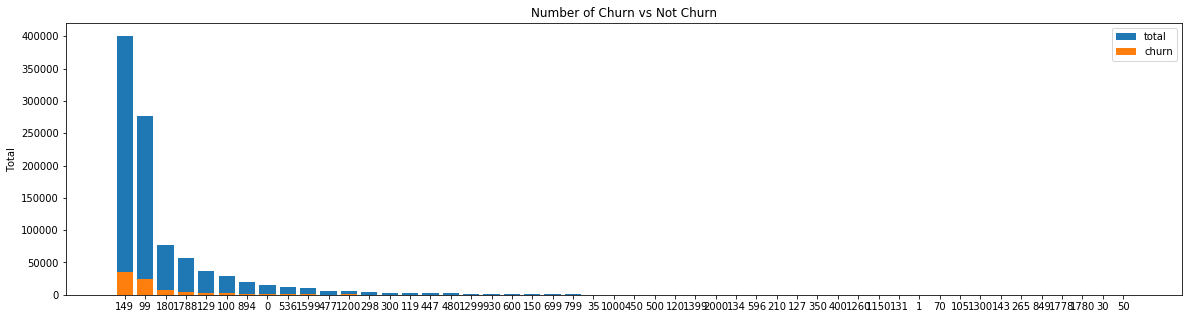

    actual_amount_paid  is_churn   total       Avg
16                 149     36034  400480  0.089977
6                   99     24944  276882  0.090089
18                 180      6844   76526  0.089434
48                1788      5105   56985  0.089585
12                 129      3296   36172  0.091120
7                  100      2670   29764  0.089706
36                 894      1817   20117  0.090322
0                    0      1295   14573  0.088863
30                 536      1140   12462  0.091478
45                1599       899   10004  0.089864
27                 477       449    5420  0.082841
40                1200       470    5152  0.091227
21                 298       343    4099  0.083679
22                 300       254    3228  0.078686
9                  119       252    2748  0.091703
25                 447       233    2730  0.085348
28                 480       229    2588  0.088485
42                1299       193    2009  0.096068
37                 930       18

In [496]:
univariate_barplots(train, 'actual_amount_paid', 'is_churn', False)

__SUMMARY: Almost all the higher price has higher churn rate __

### 3.11 Univariate Analysis: is_auto_renew

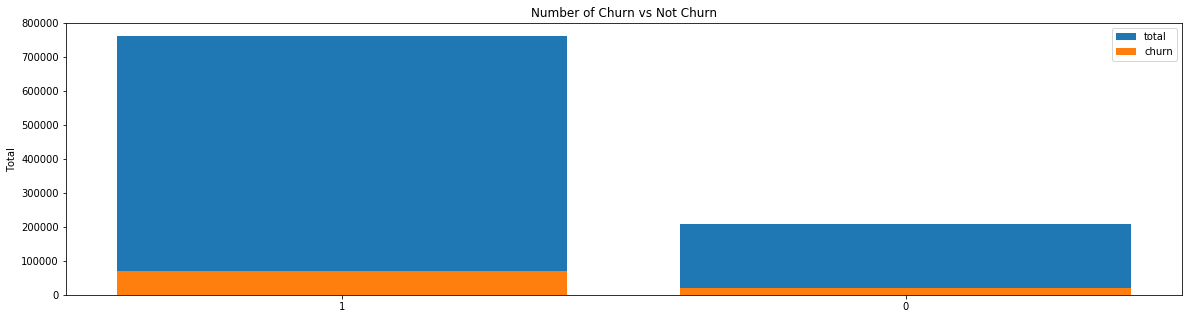

   is_auto_renew  is_churn   total       Avg
1              1     68636  762476  0.090017
0              0     18694  208484  0.089666


In [501]:
univariate_barplots(train, 'is_auto_renew', 'is_churn', False)

__SUMMARY: Auto renew rate is little bit high for churn users __

### 3.12 Univariate Analysis: is_cancel


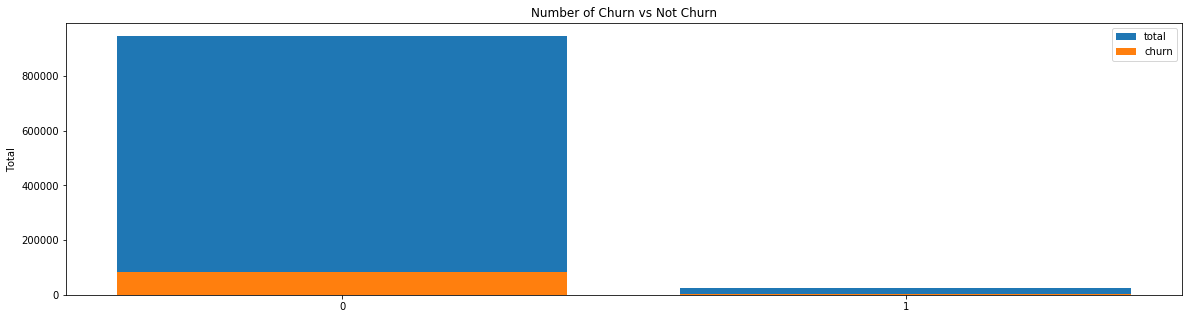

   is_cancel  is_churn   total       Avg
0          0     85136  946989  0.089902
1          1      2194   23971  0.091527


In [502]:
univariate_barplots(train, 'is_cancel', 'is_churn', False)

__SUMMARY: If the users opted to cancel, they are more likely to churn __

### 3.13 Univariate Analysis: transaction_date


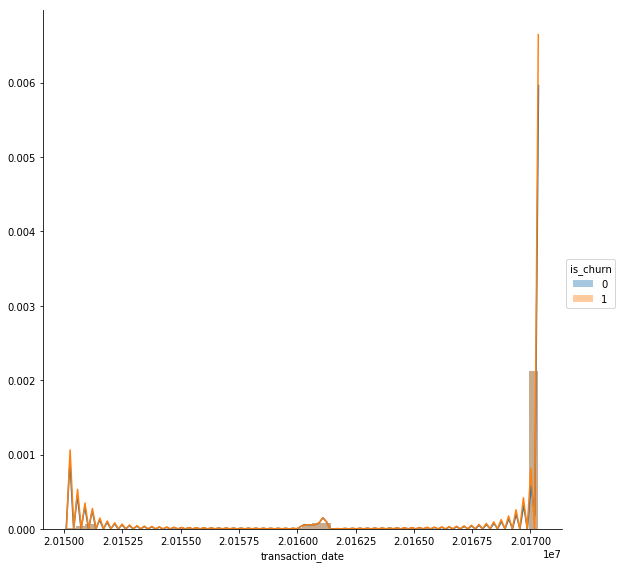

In [503]:
sns.FacetGrid(train, hue="is_churn", size=8) \
   .map(sns.distplot, "transaction_date") \
   .add_legend();
plt.show();

__SUMMARY: In the year 2017 there are more numbers of transactions __

In [ ]:
## filtered out the year

### 3.14 Univariate Analysis: membership_expire_date


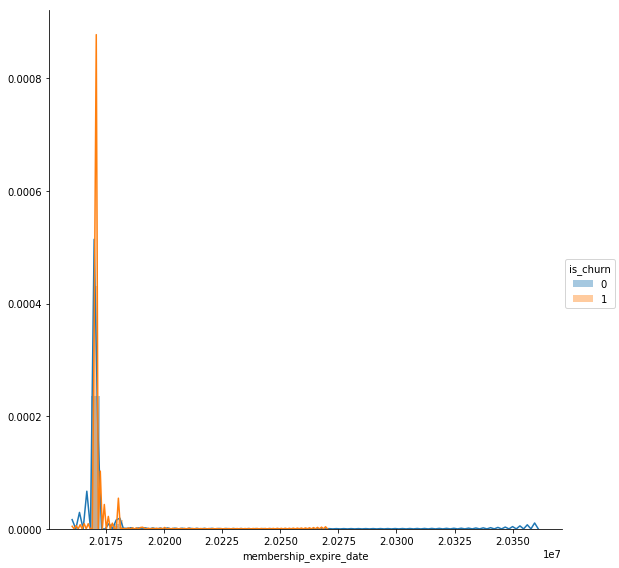

In [504]:
sns.FacetGrid(train, hue="is_churn", size=8) \
   .map(sns.distplot, "membership_expire_date") \
   .add_legend();
plt.show();

__SUMMARY: Early expiry dates has higher churn rate __

### 3.14 Univariate Analysis: total_secs


In [505]:
churn = train[train['is_churn']==1]['total_secs'].values
not_churn = train[train['is_churn']==0]['total_secs'].values



In [506]:
def logs(churn,not_churn):
    plt.boxplot([churn,not_churn])
    plt.title('numbers of seconds listened')
    plt.xticks([1,2],('churn','not churn'))
    plt.ylabel('numbers of seconds')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10,3))
    sns.distplot(churn, hist=False, label="Churn")
    sns.distplot(not_churn, hist=False, label="Not Churn")
    plt.title('numbers of seconds listened')
    plt.xlabel('numbers of seconds')
    plt.legend()
    plt.show()

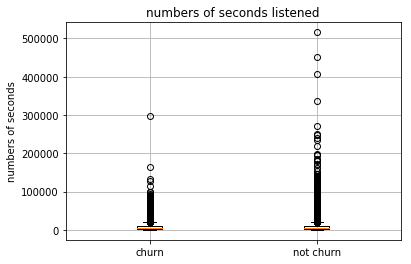

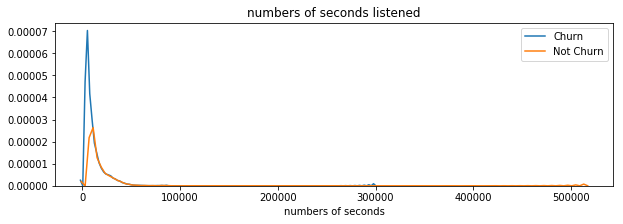

In [507]:
logs(churn,not_churn)

In [508]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

7992.6879363449
7911.890802334688


__SUMMARY: Churned members have listened more songs __

### 3.14 Univariate Analysis: num_25


In [509]:
churn = train[train['is_churn']==1]['num_25'].values
not_churn = train[train['is_churn']==0]['num_25'].values

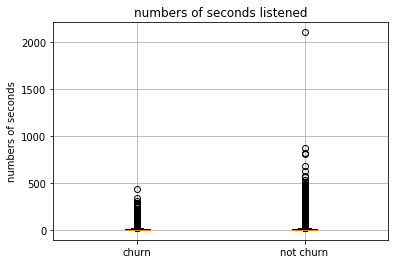

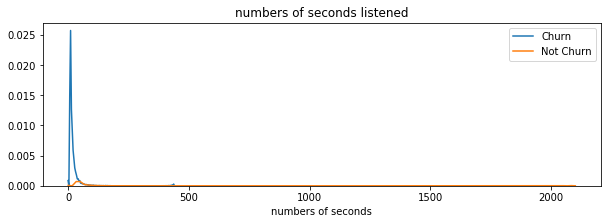

In [510]:
logs(churn,not_churn)

In [511]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

6.264823084850566
6.188915043626857


__SUMMARY: Churned members have listened more songs __

### 3.15 Univariate Analysis: num_50


In [512]:
churn = train[train['is_churn']==1]['num_50'].values
not_churn = train[train['is_churn']==0]['num_50'].values

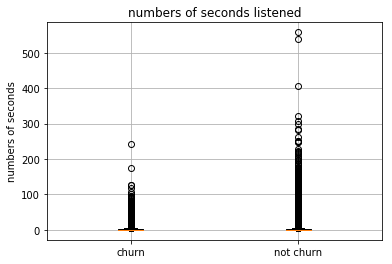

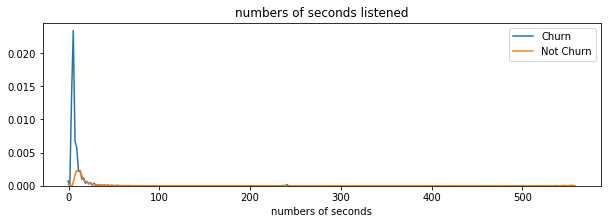

In [513]:
logs(churn,not_churn)

In [514]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

1.5263597847246078
1.5075846225230016


__SUMMARY: Churned members have listened more songs __

### 3.15 Univariate Analysis: num_75


In [515]:
churn = train[train['is_churn']==1]['num_75'].values
not_churn = train[train['is_churn']==0]['num_75'].values

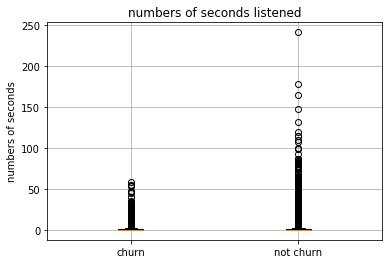

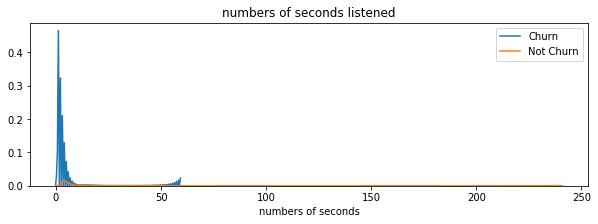

In [516]:
logs(churn,not_churn)

In [517]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

0.9451391274476125
0.9429421816823784


__SUMMARY: Churned members have listened more songs __

### 3.15 Univariate Analysis: num_985


In [518]:
churn = train[train['is_churn']==1]['num_985'].values
not_churn = train[train['is_churn']==0]['num_985'].values

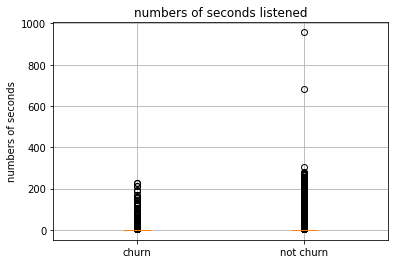

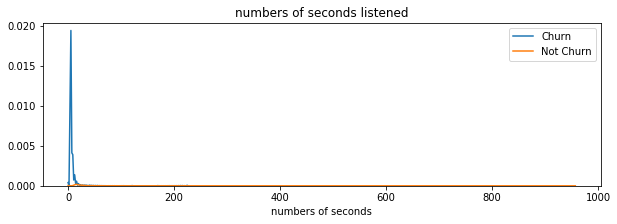

In [519]:
logs(churn,not_churn)

In [520]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

1.090999656475438
1.0812081980014259


__SUMMARY: Churned members have listened more songs __

### 3.15 Univariate Analysis: num_100


In [521]:
churn = train[train['is_churn']==1]['num_100'].values
not_churn = train[train['is_churn']==0]['num_100'].values

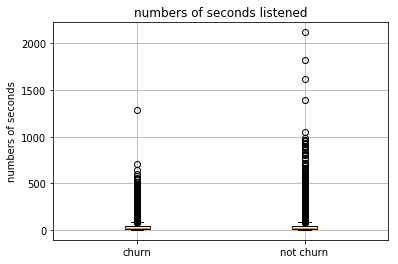

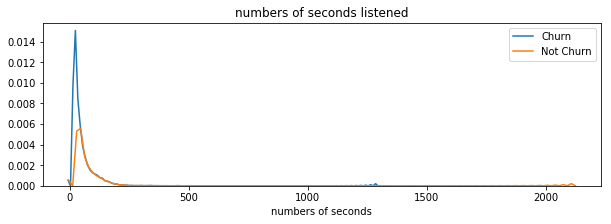

In [522]:
logs(churn,not_churn)

In [523]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

30.62484827665178
30.3076638412005


__SUMMARY: Churned members have listened more songs __

### 3.15 Univariate Analysis: num_unq


In [524]:
churn = train[train['is_churn']==1]['num_unq'].values
not_churn = train[train['is_churn']==0]['num_unq'].values

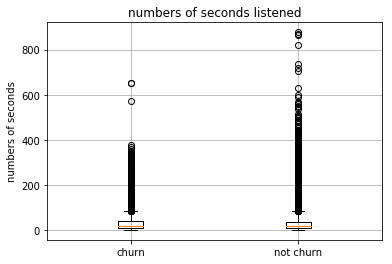

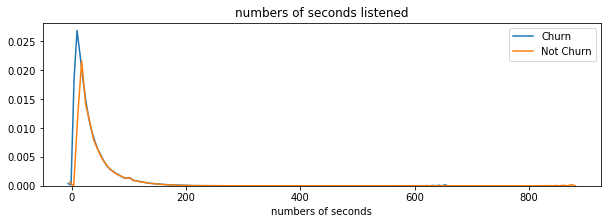

In [525]:
logs(churn,not_churn)

In [526]:
a = np.array(churn)
print(np.mean(a))
a = np.array(not_churn)
print(np.mean(a))

29.35607465933814
29.063857044237974


__SUMMARY: Churned members have listened more songs __

__SUMMARY: From the logs mean rate of churn user's are higher than non churn users__